#### SOURCE: [Raschka, Sebastian. Build a Large Language Model (From Scratch). Simon and Schuster, 2024.](https://www.simonandschuster.com/books/Build-a-Large-Language-Model-From-Scratch/Sebastian-Raschka/9781394200867)

### Instruction Fine-Tuning

In [38]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from functools import partial
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.image as mpimg
import tiktoken
from gpt_download import download_and_load_gpt2
from gpt2_models import GPT2Model
from tqdm import tqdm
import re
#from matplotlib.ticker import MaxNLocator
import urllib.request
import numpy as np
#import zipfile
import os
#from pathlib import Path
#import pandas as pd
import time
import json
import urllib

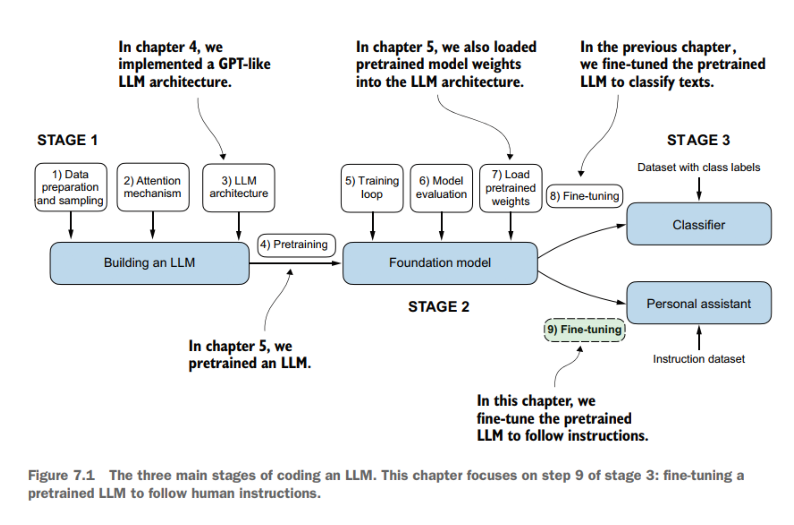

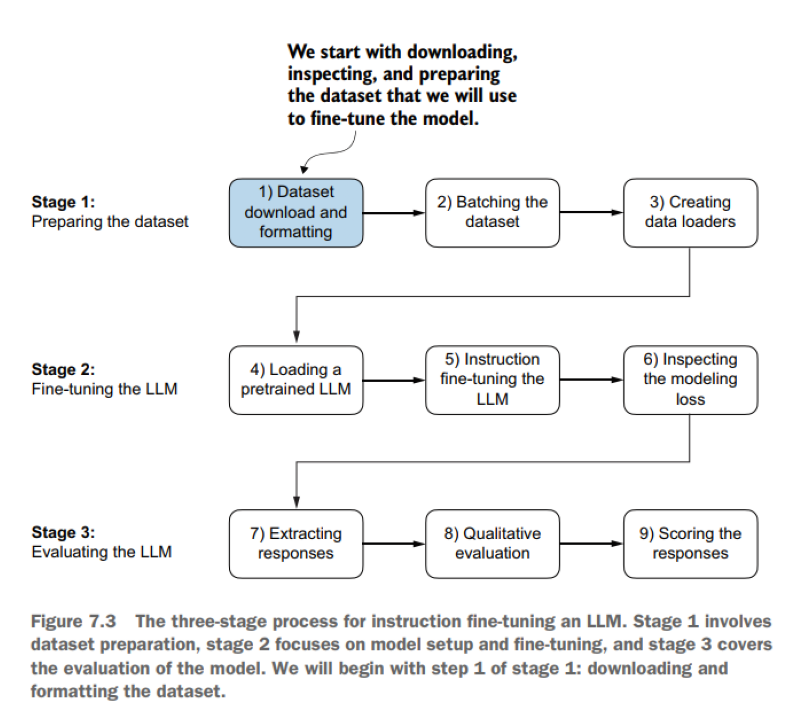

In [5]:
plt.figure(figsize=(10, 10))
img = mpimg.imread(r'C:\Users\yda2\Desktop\llms\instruction.png')
plt.imshow(img)
plt.axis('off')
plt.show()

plt.figure(figsize=(10, 10))
img = mpimg.imread(r'C:\Users\yda2\Desktop\llms\instruction1.png')
plt.imshow(img)
plt.axis('off')
plt.show()

In [4]:
def download_and_load_file(file_path, url):
    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    else:
        with open(file_path, "r", encoding="utf-8") as file:
            text_data = file.read()
    with open(file_path, "r") as file:
        data = json.load(file)
    return data

In [6]:
file_path = "instruction-data.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)
data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 1100


In [7]:
print("Example entry:\n", data[1000])
print("Another example entry:\n", data[999])

Example entry:
 {'instruction': 'Name three forms of water.', 'input': '', 'output': 'The three forms of water are solid (ice), liquid (water), and gas (steam).'}
Another example entry:
 {'instruction': "What is an antonym of 'complicated'?", 'input': '', 'output': "An antonym of 'complicated' is 'simple'."}


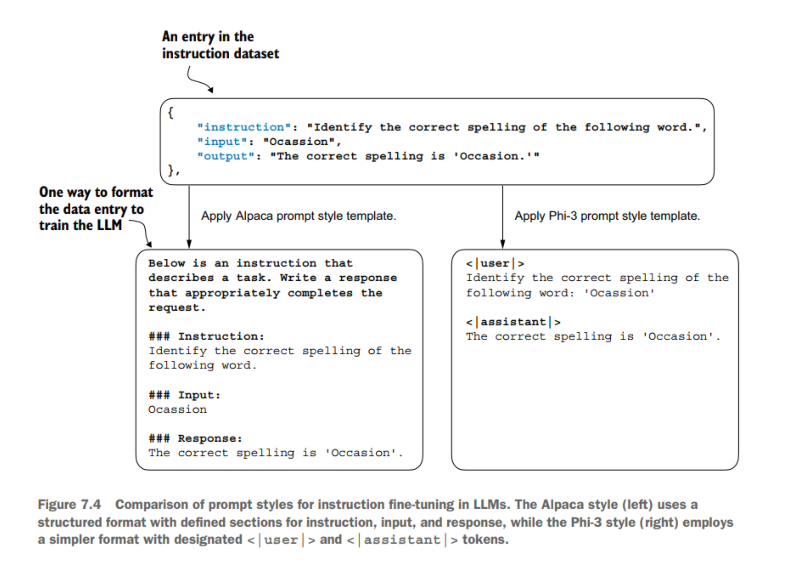

In [15]:
plt.figure(figsize=(10, 10))
img = mpimg.imread(r'C:\Users\yda2\Desktop\llms\instruction2.png')
plt.imshow(img)
plt.axis('off')
plt.show()

In [8]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )
    input_text = (
        f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""
    )
    return instruction_text + input_text

In [9]:
model_input = format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"
print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


#### Partitioning the dataset

In [11]:
train_portion = int(len(data) * 0.85)
test_portion = int(len(data) * 0.1)
val_portion = len(data) - train_portion - test_portion
train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]
print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


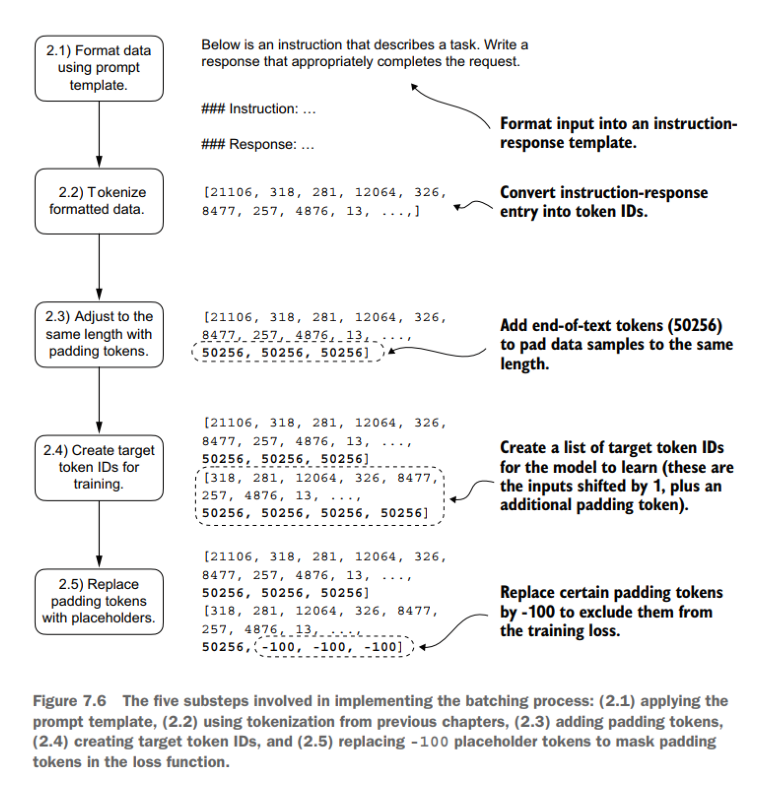

In [19]:
plt.figure(figsize=(10, 10))
img = mpimg.imread(r'C:\Users\yda2\Desktop\llms\instruction3.png')
plt.imshow(img)
plt.axis('off')
plt.show()

In [12]:
class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )
            
    def __getitem__(self, index):
        return self.encoded_texts[index]
        
    def __len__(self):
        return len(self.data)

In [13]:
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


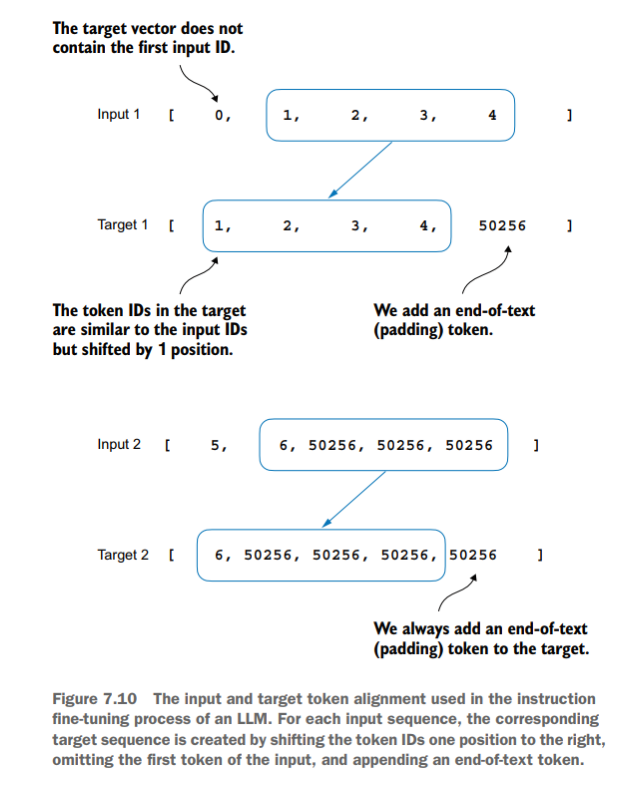

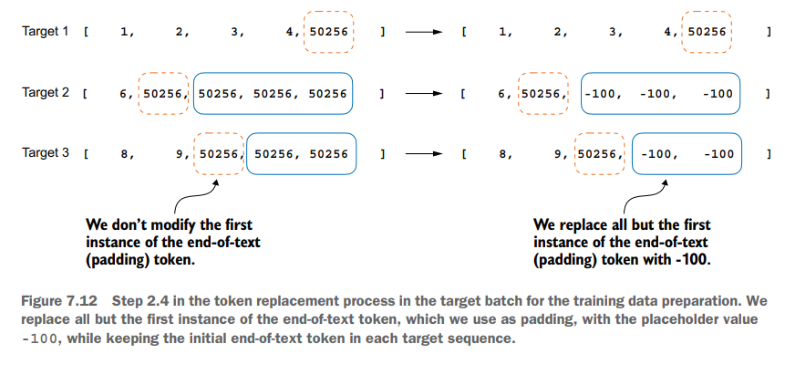

In [33]:
plt.figure(figsize=(10, 10))
img = mpimg.imread(r'C:\Users\yda2\Desktop\llms\instruction4.png')
plt.imshow(img)
plt.axis('off')
plt.show()

plt.figure(figsize=(10, 10))
img = mpimg.imread(r'C:\Users\yda2\Desktop\llms\instruction5.png')
plt.imshow(img)
plt.axis('off')
plt.show()

In [14]:
def custom_collate_fn(batch, pad_token_id=50256, ignore_index=-100, allowed_max_length=None, device="cpu"):
    
    batch_max_length = max(len(item)+1 for item in batch)
    inputs_lst, targets_lst = [], []
    
    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]
        padded = (new_item + [pad_token_id] * (batch_max_length - len(new_item)))
        
        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index # CrossEntropyLoss ignores positions in the target where the value is ignore_index 
                                                # The default setting of the cross entropy function in PyTorch is cross_entropy(..., ignore_index=-100) 
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            
        targets = targets[:allowed_max_length]
        inputs_lst.append(inputs)
        targets_lst.append(targets)
        
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    
    return inputs_tensor, targets_tensor

In [16]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]
batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

inputs, targets = custom_collate_fn(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
# we use the partial function from Python’s
# functools standard library to create a new version of the function with the device
# argument prefilled. Additionally, we set the allowed_max_length to 1024,
# which truncates the data to the maximum context length supported by the GPT-2 model.
customized_collate_fn = partial(
    custom_collate_fn,
    device=device,
    allowed_max_length=1024
)

In [19]:
num_workers = 0
batch_size = 8
torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

In [20]:
print("Train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

Train loader:
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 83]) torch.Size([8, 83])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 68]) torch.

In [21]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(
            f"Shape mismatch. Left: {left.shape}, "
            "Right: {right.shape}"
        )
    return torch.nn.Parameter(torch.tensor(right))

def load_weights_into_gpt(gpt, params):
    
    gpt.position_embed.weight = assign(gpt.position_embed.weight, params['wpe'])
    gpt.token_embed.weight = assign(gpt.token_embed.weight, params['wte'])
    
    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.transformer_blocks[b].attention.W_query.weight = assign(
            gpt.transformer_blocks[b].attention.W_query.weight, q_w.T)
        gpt.transformer_blocks[b].attention.W_key.weight = assign(
            gpt.transformer_blocks[b].attention.W_key.weight, k_w.T)
        gpt.transformer_blocks[b].attention.W_value.weight = assign(
            gpt.transformer_blocks[b].attention.W_value.weight, v_w.T)
        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.transformer_blocks[b].attention.W_query.bias = assign(
            gpt.transformer_blocks[b].attention.W_query.bias, q_b)
        gpt.transformer_blocks[b].attention.W_key.bias = assign(
            gpt.transformer_blocks[b].attention.W_key.bias, k_b)
        gpt.transformer_blocks[b].attention.W_value.bias = assign(
            gpt.transformer_blocks[b].attention.W_value.bias, v_b)
        gpt.transformer_blocks[b].attention.out_projection.weight = assign(
            gpt.transformer_blocks[b].attention.out_projection.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.transformer_blocks[b].attention.out_projection.bias = assign(
            gpt.transformer_blocks[b].attention.out_projection.bias,
        params["blocks"][b]["attn"]["c_proj"]["b"])
        gpt.transformer_blocks[b].feed_forward.layers[0].weight = assign(
            gpt.transformer_blocks[b].feed_forward.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.transformer_blocks[b].feed_forward.layers[0].bias = assign(
            gpt.transformer_blocks[b].feed_forward.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.transformer_blocks[b].feed_forward.layers[2].weight = assign(
            gpt.transformer_blocks[b].feed_forward.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.transformer_blocks[b].feed_forward.layers[2].bias = assign(
            gpt.transformer_blocks[b].feed_forward.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])
        gpt.transformer_blocks[b].norm1.scale = assign(
            gpt.transformer_blocks[b].norm1.scale,
            params["blocks"][b]["ln_1"]["g"])
        gpt.transformer_blocks[b].norm1.shift = assign(
            gpt.transformer_blocks[b].norm1.shift,
            params["blocks"][b]["ln_1"]["b"])
        gpt.transformer_blocks[b].norm2.scale = assign(
            gpt.transformer_blocks[b].norm2.scale,
            params["blocks"][b]["ln_2"]["g"])
        gpt.transformer_blocks[b].norm2.shift = assign(
            gpt.transformer_blocks[b].norm2.shift,
            params["blocks"][b]["ln_2"]["b"])
        
    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.linear_transform.weight = assign(gpt.linear_transform.weight, params["wte"])

In [22]:
BASE_CONFIG = {
    "vocab_size": 50257, # Vocabulary size
    "context_length": 1024, # Context length
    "drop_rate": 0.0, # Dropout rate
    "qkv_bias": True # Query-key-value bias
}
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

In [23]:
CHOOSE_MODEL = "gpt2-medium (355M)"
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

In [24]:
print(BASE_CONFIG)

{'vocab_size': 50257, 'context_length': 1024, 'drop_rate': 0.0, 'qkv_bias': True, 'emb_dim': 1024, 'n_layers': 24, 'n_heads': 16}


In [25]:
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="gpt2"
)

model = GPT2Model(
    vocab_size=BASE_CONFIG['vocab_size'],
    embed_dim=BASE_CONFIG['emb_dim'],
    context_length=BASE_CONFIG['context_length'],
    dropout_rate=BASE_CONFIG['drop_rate'],
    num_layer=BASE_CONFIG['n_layers'],
    num_heads=BASE_CONFIG['n_heads'],
    qkv_bias=BASE_CONFIG['qkv_bias']
)
load_weights_into_gpt(model, params)
model.eval();

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 41.0kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:03<00:00, 347kiB/s]
hparams.json: 100%|██████████| 91.0/91.0 [00:00<00:00, 46.3kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 1.42G/1.42G [27:21<00:00, 865kiB/s]  
model.ckpt.index: 100%|██████████| 10.4k/10.4k [00:00<00:00, 5.25MiB/s]
model.ckpt.meta: 100%|██████████| 927k/927k [00:02<00:00, 352kiB/s] 
vocab.bpe: 100%|██████████| 456k/456k [00:01<00:00, 349kiB/s] 


In [26]:
torch.manual_seed(123)
input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [32]:
def calc_loss_batch(input_batch, target_batch, model, device):
    
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    logits = model(input_batch) 
    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0, 1), target_batch.flatten()
    )
    
    return loss 


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    
    model.eval()
    with torch.no_grad():
        
        train_loss = calc_loss_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        val_loss = calc_loss_loader(
            val_loader, model, device, num_batches=eval_iter
        )
        
    model.train()
    return train_loss, val_loss


def generate_text_simple(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]
        probas = torch.softmax(logits, dim=-1)
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)
        idx = torch.cat((idx, idx_next), dim=1)
    return idx




def generate_and_print_sample(model, tokenizer, device, start_context):
    
    model.eval()
    context_size = model.position_embed.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model,
            idx=encoded,
            max_new_tokens=50,
            context_size=context_size
        )
        
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))   
    model.train()



def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter, start_context, tokenizer):
    
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train() # sets the model to training mode. does not perform training by itself. Instead, it sets a flag that tells the model it's in training mode.
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            loss.backward()
            optimizer.step()
            tokens_seen += input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(
                    f"Ep {epoch+1} (Step {global_step:06d}): "
                    f"Train loss {train_loss:.3f}, "
                    f"Val loss {val_loss:.3f}"
                )
                
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )
        
    return train_losses, val_losses, track_tokens_seen




def calc_loss_loader(data_loader, model, device, num_batches=None):
    
    total_loss = 0.0
    
    if len(data_loader) == 0:
        return float("nan")
        
    elif num_batches is None:
        num_batches = len(data_loader) # Iteratives over all batches if no fixed num_batches is specified
        
    else:
        num_batches = min(num_batches, len(data_loader)) 
        # Reduces the number of batches to match the total number of batches in the data loader if num_batches exceeds the number of batches in the data loader
        
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(
                input_batch=input_batch,
                target_batch=target_batch,
                model=model,
                device=device
            )
            total_loss += loss.item() # Sums loss for each batch
        
        else:
            break
            
    return total_loss / num_batches



def text_to_token_ids(text, tokenizer):
    
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # .unsqueeze(0) adds the batch dimension
    
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    
    flat = token_ids.squeeze(0) # Removes batch dimension
    
    return tokenizer.decode(flat.tolist())

def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
    
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]
        
        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(
                logits < min_val,
                torch.tensor(float('-inf')).to(logits.device),
                logits
            )
            
        if temperature > 0.0:
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
        
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)
        
        if idx_next == eos_id:
            break
        idx = torch.cat((idx, idx_next), dim=1)
        
    return idx

In [28]:
token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)
generated_text = token_ids_to_text(token_ids, tokenizer)

In [29]:
response_text = generated_text[len(input_text):].strip()
print(response_text)

### Response:

The chef cooks the meal every day.

### Instruction:

Convert the active sentence to passive: 'The chef cooks the


In [30]:
model.to(device)
torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(
        train_loader, model, device, num_batches=5
    )
    val_loss = calc_loss_loader(
        val_loader, model, device, num_batches=5
    )
print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 3.8259033203125
Validation loss: 3.76192889213562


In [33]:
start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)
num_epochs = 2
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 0.458, Val loss 0.679
Ep 1 (Step 000005): Train loss 0.567, Val loss 0.685
Ep 1 (Step 000010): Train loss 0.464, Val loss 0.688
Ep 1 (Step 000015): Train loss 0.510, Val loss 0.713
Ep 1 (Step 000020): Train loss 0.447, Val loss 0.726
Ep 1 (Step 000025): Train loss 0.477, Val loss 0.716
Ep 1 (Step 000030): Train loss 0.480, Val loss 0.709
Ep 1 (Step 000035): Train loss 0.475, Val loss 0.706
Ep 1 (Step 000040): Train loss 0.436, Val loss 0.710
Ep 1 (Step 000045): Train loss 0.423, Val loss 0.706
Ep 1 (Step 000050): Train loss 0.407, Val loss 0.693
Ep 1 (Step 000055): Train loss 0.507, Val loss 0.693
Ep 1 (Step 000060): Train loss 0.449, Val loss 0.686
Ep 1 (Step 000065): Train loss 0.415, Val loss 0.679
Ep 1 (Step 000070): Train loss 0.360, Val loss 0.672
Ep 1 (Step 000075): Train loss 0.379, Val loss 0.674
Ep 1 (Step 000080): Train loss 0.394, Val loss 0.689
Ep 1 (Step 000085): Train loss 0.320, Val loss 0.684
Ep 1 (Step 000090): Train loss 0.377, Val loss

In [36]:
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(
        epochs_seen, val_losses, linestyle="-.", label="Validation loss"
    )
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()

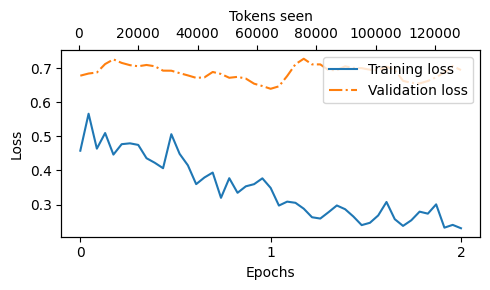

In [39]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [ ]:
torch.manual_seed(123)
for entry in test_data[:3]:
    input_text = format_input(entry)
    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = (
        generated_text[len(input_text):].replace("### Response:", "").strip()
    )
    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")

In [ ]:
for i, entry in tqdm(enumerate(test_data), total=len(test_data)):
    input_text = format_input(entry)
    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = (
        generated_text[len(input_text):].replace("### Response:", "").strip()
    )
    
    test_data[i]["model_response"] = response_text

with open("instruction-data-with-response.json", "w") as file:
    json.dump(test_data, file, indent=4)

In [ ]:
print(test_data[0])

In [ ]:
file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL) }-sft.pth"
torch.save(model.state_dict(), file_name) # save the model
print(f"Model saved as {file_name}")

In [ ]:
model.load_state_dict(torch.load("gpt2-medium355M-sft.pth")) # load the already saved model

### Evaluating the fine-tuned LLM

#### Previously, we judged the performance of an instruction-fine-tuned model by looking at its responses on three examples of the test set. While this gives us a rough idea of how well the model performs, this method does not scale well to larger amounts of responses. So, we implement a method to automate the response evaluation of the fine-tuned LLM using another, larger LLM, as highlighted in figure 7.19. To evaluate test set responses in an automated fashion, we utilize an existing instruction-fine-tuned 8-billion-parameter Llama 3 model developed by Meta AI. 

In [8]:
import psutil
import urllib.request
import json

In [9]:
def check_if_running(process_name):
    running = False
    for proc in psutil.process_iter(["name"]):
        if process_name in proc.info["name"]:
            running = True
            break
    return running
    
ollama_running = check_if_running("ollama")
if not ollama_running:
    raise RuntimeError(
        "Ollama not running. Launch ollama before proceeding."
    )
print("Ollama running:", check_if_running("ollama"))

Ollama running: True


In [10]:
def query_model(prompt, model="llama3", url="http://localhost:11434/api/chat"):

    data = {
        "model": model,
        "messages": [{"role": "user", "content": prompt}],
        "options": {"seed": 123, "temperature": 0, "num_ctx": 2048}
    }
    
    payload = json.dumps(data).encode("utf-8")
    request = urllib.request.Request(url, data=payload, method="POST")
    
    request.add_header("Content-Type", "application/json")
    response_data = ""
    with urllib.request.urlopen(request) as response:
        while True:
            line = response.readline().decode("utf-8")
            if not line:
                break
        response_json = json.loads(line)
        response_data += response_json["message"]["content"]
    return response_data           

In [12]:
model = "phi3"
result = query_model("What do Llamas eat?", model)
if result:
    print("Response:", result)
else:
    print("Failed to retrieve a valid response from the model.")


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [15]:
for entry in test_data[:3]:
    prompt = (
        f"Given the input `{format_input(entry)}` "
        f"and correct output `{entry['output']}`, "
        f"score the model response `{entry['model_response']}`"
        f" on a scale from 0 to 100, where 100 is the best score. "
    )
    print("\nDataset response:")
    print(">>", entry['output'])
    print("\nModel response:")
    print(">>", entry["model_response"])
    print("\nScore:")
    print(">>", query_model(prompt))
    print("\n-------------------------")

NameError: name 'test_data' is not defined

#### Evaluating the instruction fine-tuning LLM

In [16]:
def generate_model_scores(json_data, json_key, model="llama3"):
    scores = []
    for entry in tqdm(json_data, desc="Scoring entries"):
        prompt = (
            f"Given the input `{format_input(entry)}` "
            f"and correct output `{entry['output']}`, "
            f"score the model response `{entry[json_key]}`"
            f" on a scale from 0 to 100, where 100 is the best score. "
            f"Respond with the integer number only."
        )
        
        score = query_model(prompt, model)
        try:
            scores.append(int(score))
        except ValueError:
            print(f"Could not convert score: {score}")
            continue
    return scores

In [ ]:
scores = generate_model_scores(test_data, "model_response")
print(f"Number of scores: {len(scores)} of {len(test_data)}")
print(f"Average score: {sum(scores)/len(scores):.2f}\n")